In [1]:
%config IPCompleter.greedy=True

In [2]:
import librosa
import librosa.display
import numpy as np
import pandas as pd
import ffmpeg as ff
import os
from typing import List, Tuple, Dict
import matplotlib.pyplot as plt
import random
import cv2
import pickle
import datetime

In [ ]:
def extract_audio_from_video(file_path: str) -> np.ndarray:
    inputfile = ff.input(file_path)
    out = inputfile.output('-', format='f32le', acodec='pcm_f32le', ac=1, ar='44100')
    raw = out.run(capture_stdout=True)
    del inputfile, out
    return np.frombuffer(raw[0],np.float32)

In [ ]:
def preprocess_audio_series(raw_data: np.ndarray) -> np.ndarray:
    N, M = 24, 1319
    mfcc_data = librosa.feature.mfcc(raw_data, n_mfcc= 24)
    
    #Getting spectral mean (centroid)
    #mean = librosa.feature.spectral_centroid(result)
    
    #Standardizing MFCC (zero mean and unit variance)
    mfcc_data_standardized = (mfcc_data - np.mean(mfcc_data)) / np.std(mfcc_data)
    
    # Use pre-padding (Note: with 0, which is also the mean after standardization) to unify the length of the samples.
    number_of_columns_to_fill = M - mfcc_data_standardized.shape[1]
    padding = np.zeros((N,number_of_columns_to_fill))
    
    padded_data = np.hstack((padding, mfcc_data_standardized))
    
    #Reshaping to N,M,1
    return padded_data.reshape(N,M,1)

In [ ]:
def get_number_of_frames(file_path: str) -> int:
    probe = ff.probe(filePath)
    video_streams = [stream for stream in probe["streams"] if stream["codec_type"] == "video"]
    #width = video_streams[0]['coded_width']
    #height = video_streams[0]['coded_height']
    del probe
    return video_streams[0]['nb_frames']

In [ ]:
def extract_N_video_frames(file_path: str, number_of_samples: int = 6) -> List[np.ndarray]:
    nb_frames = int(get_number_of_frames(file_path= filePath))
    
    video_frames = []
    random_indexes = random.sample(range(0, nb_frames), number_of_samples)
    
    cap = cv2.VideoCapture(filePath)
    for ind in random_indexes:
        cap.set(1,ind)
        res, frame = cap.read()
        video_frames.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    cap.release()
    del cap, random_indexes
    return video_frames

In [ ]:
def resize_image(image: np.ndarray, new_size: Tuple[int,int]) -> np.ndarray:
    return cv2.resize(image, new_size, interpolation = cv2.INTER_AREA)

In [ ]:
def crop_image_window(image: np.ndarray, training: bool = True) -> np.ndarray:
    height, width, _ = image.shape
    if training:
        MAX_N = height - 128
        MAX_M = width - 128
        rand_N_index, rand_M_index = random.randint(0, MAX_N) , random.randint(0, MAX_M)
        return image[rand_N_index:(rand_N_index+128),rand_M_index:(rand_M_index+128),:]
    else:
        N_index = (height - 128) // 2
        M_index = (width - 128) // 2
        return image[N_index:(N_index+128),M_index:(M_index+128),:]

In [ ]:
def reading_label_data(file_name: str, dictionary: Dict[str,str]) -> np.ndarray:
    features = ['extraversion', 'neuroticism', 'agreeableness', 'conscientiousness', 'openness']
    extracted_data = [float(dictionary[label][file_name]) for label in features]
    return np.stack(extracted_data).reshape(5,1)

In [ ]:
def preprocessing_input(file_path: str, file_name: str, dictionary: Dict[str,str], training: bool = True) -> Tuple[np.ndarray,np.ndarray,np.ndarray]:
    #Audio
    extracted_audio_raw = extract_audio_from_video(file_path= filePath)
    preprocessed_audio = preprocess_audio_series(raw_data= extracted_audio_raw)
    
    #Video
    sampled = extract_N_video_frames(file_path= filePath, number_of_samples= 6)
    resized_images = [resize_image(image= im, new_size= (248,140)) for im in sampled]
    cropped_images = [crop_image_window(image= resi,training= training) / 255.0 for resi in resized_images]
    preprocessed_video = np.stack(cropped_images)
    
    #Ground Truth
    video_gt = reading_label_data(file_name= file_name, dictionary= dictionary)
    del extracted_audio_raw, sampled, resized_images, cropped_images
    return (preprocessed_audio, preprocessed_video, video_gt)

### Getting train set

In [ ]:
training_set_data = []
path = 'Big5/train'
gt = pickle.load( open( "Big5/gt/annotation_training.pkl", "rb" ), encoding='latin1' )
t1 = datetime.datetime.utcnow()
for filename in os.listdir(path):
    filePath = path+'/'+filename
    training_set_data.append(preprocessing_input(file_path= filePath, file_name= filename, dictionary= gt, training= True))
t2 = datetime.datetime.utcnow()
#Measuring execution time
print('Elapsed time: ' + str(t2-t1))

In [ ]:
savename = 'training_set.dat'
with open(savename, "wb") as f:
    pickle.dump(training_set_data, f)

### Getting validation set

In [ ]:
validation_set_data = []
path = 'Big5/valid'
gt = pickle.load( open( "Big5/gt/annotation_validation.pkl", "rb" ), encoding='latin1' )
t1 = datetime.datetime.utcnow()
for filename in os.listdir(path):
    filePath = path+'/'+filename
    validation_set_data.append(preprocessing_input(file_path= filePath, file_name= filename, dictionary= gt, training= False))
t2 = datetime.datetime.utcnow()
#Measuring execution time
print('Elapsed time: ' + str(t2-t1))

In [ ]:
savename = 'validation_set.dat'
with open(savename, "wb") as f:
    pickle.dump(validation_set_data, f)

### Getting test set

In [ ]:
test_set_data = []
path = 'Big5/test'
gt = pickle.load( open( "Big5/gt/annotation_test.pkl", "rb" ), encoding='latin1' )
t1 = datetime.datetime.utcnow()
for filename in os.listdir(path):
    filePath = path+'/'+filename
    test_set_data.append(preprocessing_input(file_path= filePath, file_name= filename, dictionary= gt, training= False))
t2 = datetime.datetime.utcnow()
#Measuring execution time
print('Elapsed time: ' + str(t2-t1))

In [ ]:
savename = 'test_set.dat'
with open(savename, "wb") as f:
    pickle.dump(test_set_data, f)

### Restarting kernel to free up memory, and then load data

In [3]:
with open('training_set.dat', "rb") as training_file:
    train_set_data = pickle.load(training_file)

In [4]:
with open('validation_set.dat', "rb") as validation_file:
    validation_set_data = pickle.load(validation_file)

In [5]:
with open('test_set.dat', "rb") as test_file:
    test_set_data = pickle.load(test_file)

<AxesSubplot:ylabel='Density'>

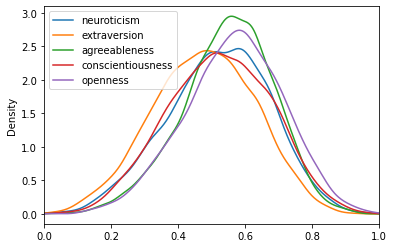

In [6]:
gt = pickle.load( open( "Big5/gt/annotation_training.pkl", "rb" ), encoding='latin1' )
neuroticism = list(gt['neuroticism'].values())
extraversion = list(gt['extraversion'].values())
agreeableness = list(gt['agreeableness'].values())
conscientiousness = list(gt['conscientiousness'].values())
openness = list(gt['openness'].values())

df = pd.DataFrame({'neuroticism': neuroticism,'extraversion': extraversion,'agreeableness':agreeableness,'conscientiousness':conscientiousness,'openness':openness})
df.plot(kind='density',xlim=(0,1))

### Plotting number of samples in each set

In [7]:
print(len(train_set_data))
print(len(validation_set_data))
print(len(test_set_data))

6000
2000
2000


In [11]:
train_random_index = random.randint(0, len(train_set_data)-1)
validation_random_index = random.randint(0, len(validation_set_data)-1)
test_random_index = random.randint(0, len(test_set_data)-1)

In [12]:
shape = train_set_data[train_random_index][0].shape
mfcc_train = train_set_data[train_random_index][0].reshape(shape[0],shape[1])

shape = validation_set_data[validation_random_index][0].shape
mfcc_validation = validation_set_data[validation_random_index][0].reshape(shape[0],shape[1])

shape = test_set_data[test_random_index][0].shape
mfcc_train = test_set_data[test_random_index][0].reshape(shape[0],shape[1])

mfccs = [mfcc_train,mfcc_validation,mfcc_train]

### Displaying 3 video samples from train,validation and test sets

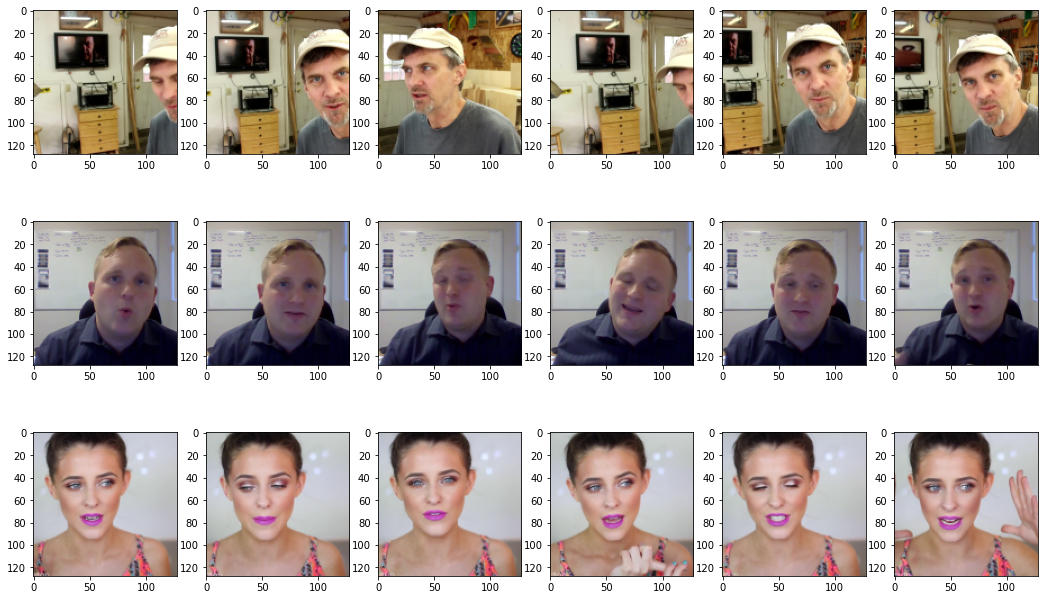

In [13]:
images_to_plot = []
images_to_plot.extend([(train_set_data[train_random_index][1])[i,:,:,:] for i in range(0,6)])
images_to_plot.extend([(validation_set_data[validation_random_index][1])[i,:,:,:] for i in range(0,6)])
images_to_plot.extend([(test_set_data[test_random_index][1])[i,:,:,:] for i in range(0,6)])
    

plt.figure(figsize=(18,11))

for i in range(18):
    plt.subplot(3,6,i+1)
    plt.imshow(images_to_plot[i])
plt.show()

### Displaying audio MFCC

C:\Users\grimm\anaconda3\envs\gputest\lib\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
C:\Users\grimm\anaconda3\envs\gputest\lib\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


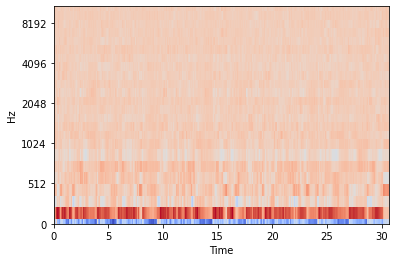

In [14]:
librosa.display.specshow(mfccs[0], x_axis='time', y_axis='mel')

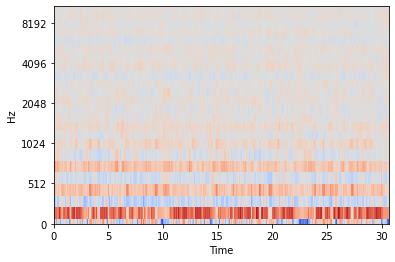

In [15]:
librosa.display.specshow(mfccs[1], x_axis='time', y_axis='mel')

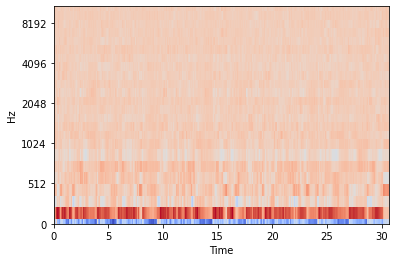

In [16]:
librosa.display.specshow(mfccs[2], x_axis='time', y_axis='mel')

### Printing personality traits

In [18]:
personality_train = train_set_data[train_random_index][2]
personality_validation = validation_set_data[validation_random_index][2]
personality_test = test_set_data[test_random_index][2]
personalities = ['Neuroticism','Extraversion','Agreeableness','Conscientiousness','Openness']

#### Train

In [19]:
for label, value in zip(personalities,personality_train):
    print(label + ': ' + str(value[0]))

Neuroticism: 0.4953271028037384
Extraversion: 0.5833333333333333
Agreeableness: 0.7142857142857143
Conscientiousness: 0.5339805825242718
Openness: 0.7888888888888888


#### Validation

In [20]:
for label, value in zip(personalities,personality_validation):
    print(label + ': ' + str(value[0]))

Neuroticism: 0.5794392523364487
Extraversion: 0.6979166666666666
Agreeableness: 0.6483516483516484
Conscientiousness: 0.8058252427184466
Openness: 0.6666666666666666


#### Test

In [21]:
for label, value in zip(personalities,personality_test):
    print(label + ': ' + str(value[0]))

Neuroticism: 0.5514018691588786
Extraversion: 0.6041666666666666
Agreeableness: 0.4835164835164835
Conscientiousness: 0.6407766990291262
Openness: 0.7666666666666666


### Converting sets to model format

In [22]:
def reshape_to_expected_input(dataset: List[Tuple[np.ndarray,np.ndarray,np.ndarray]]) -> Tuple[np.ndarray,np.ndarray,np.ndarray]:
    
    x0_list = []
    x1_list = []
    y_list = []
    for i in range(0,len(dataset)):
        x0_list.append(dataset[i][0])
        x1_list.append(dataset[i][1])
        y_list.append(dataset[i][2])
    return (np.stack(x0_list),np.stack(x1_list),np.stack(y_list))

In [23]:
train_input = reshape_to_expected_input(dataset= train_set_data)
del train_set_data
validation_input = reshape_to_expected_input(dataset= validation_set_data)
del validation_set_data
test_input = reshape_to_expected_input(dataset= test_set_data)
del test_set_data

## Creating Model

In [24]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Input, LSTM, Bidirectional, Lambda, Dropout, Concatenate
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import TimeDistributed

### Audio subnetwork

In [25]:
audio_input = Input(shape=(24,1319,1))
audio_model = Conv2D(32, kernel_size=(3,3),activation='relu')(audio_input)
audio_model = BatchNormalization()(audio_model)
audio_model = MaxPooling2D(pool_size=(2, 2))(audio_model)
audio_model = Conv2D(32, kernel_size=(3,3),activation='relu')(audio_model)
audio_model = BatchNormalization()(audio_model)
audio_model = MaxPooling2D(pool_size=(2, 2))(audio_model)
audio_model = Flatten()(audio_model)
audio_model = Dense(128, activation='relu')(audio_model)
audio_subnetwork = Model(inputs=audio_input,outputs=audio_model)

### Visual subnetwork

In [26]:
from keras.applications import vgg16

Using TensorFlow backend.


In [27]:
visual_model = Input(shape=(6,128,128,3))

cnn = vgg16.VGG16(weights="imagenet", include_top=False, pooling='max')
cnn.trainable = False

In [28]:
encoded_frame = TimeDistributed(Lambda(lambda x: cnn(x)))(visual_model)
encoded_vid = LSTM(64)(encoded_frame)

visual_subnetwork = Model(inputs=visual_model,outputs=encoded_vid)

The following Variables were used a Lambda layer's call (lambda), but
are not present in its tracked objects:
  <tf.Variable 'block1_conv1/kernel:0' shape=(3, 3, 3, 64) dtype=float32>
  <tf.Variable 'block1_conv1/bias:0' shape=(64,) dtype=float32>
  <tf.Variable 'block1_conv2/kernel:0' shape=(3, 3, 64, 64) dtype=float32>
  <tf.Variable 'block1_conv2/bias:0' shape=(64,) dtype=float32>
  <tf.Variable 'block2_conv1/kernel:0' shape=(3, 3, 64, 128) dtype=float32>
  <tf.Variable 'block2_conv1/bias:0' shape=(128,) dtype=float32>
  <tf.Variable 'block2_conv2/kernel:0' shape=(3, 3, 128, 128) dtype=float32>
  <tf.Variable 'block2_conv2/bias:0' shape=(128,) dtype=float32>
  <tf.Variable 'block3_conv1/kernel:0' shape=(3, 3, 128, 256) dtype=float32>
  <tf.Variable 'block3_conv1/bias:0' shape=(256,) dtype=float32>
  <tf.Variable 'block3_conv2/kernel:0' shape=(3, 3, 256, 256) dtype=float32>
  <tf.Variable 'block3_conv2/bias:0' shape=(256,) dtype=float32>
  <tf.Variable 'block3_conv3/kernel:0' shape=(

In [29]:
combined = Concatenate()([audio_subnetwork.output, visual_subnetwork.output])
final1 = Dense(256, activation='relu')(combined)
final2 = Dense(5, activation='linear')(final1)

In [30]:
combined_network = Model(inputs=[audio_input, visual_model], outputs=final2)
combined_network.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 24, 1319, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 22, 1317, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 22, 1317, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 11, 658, 32)  0           batch_normalization[0][0]        
____________________________________________________________________________________________

In [31]:
combined_network.compile(optimizer = 'adam',loss = 'mean_absolute_error',metrics=['mae'])

### Training

In [32]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(patience=10)

In [33]:
history = combined_network.fit(x = [train_input[0],train_input[1]],
                               y = train_input[2],
                               validation_data = ([validation_input[0],validation_input[1]],validation_input[2]),
                               epochs = 20,
                               verbose = 1,
                               callbacks = [early_stopping])

Train on 6000 samples, validate on 2000 samples
Epoch 1/20
6000/6000 [==============================] - 65s 11ms/sample - loss: 0.7185 - mae: 0.7185 - val_loss: 11.0003 - val_mae: 11.00034 - mae: 0.
Epoch 2/20
6000/6000 [==============================] - 51s 8ms/sample - loss: 0.1328 - mae: 0.1328 - val_loss: 2.1111 - val_mae: 2.1111 loss: 0.1330 - mae: 0.13 - ETA: 1s - loss: 0.1329 - mae: 0.13 - ETA: 1s - loss: 0.1329 - mae: 
Epoch 3/20
6000/6000 [==============================] - 51s 8ms/sample - loss: 0.1198 - mae: 0.1198 - val_loss: 0.1377 - val_mae: 0.1377
Epoch 4/20
6000/6000 [==============================] - 51s 8ms/sample - loss: 0.1225 - mae: 0.1225 - val_loss: 0.1123 - val_mae: 0.1123
Epoch 5/20
6000/6000 [==============================] - 51s 8ms/sample - loss: 0.1126 - mae: 0.1126 - val_loss: 0.1051 - val_mae: 0.1051
Epoch 6/20
6000/6000 [==============================] - 51s 8ms/sample - loss: 0.1040 - mae: 0.1040 - val_loss: 0.1051 - val_mae: 0.10516 - mae - ETA: 2s - lo

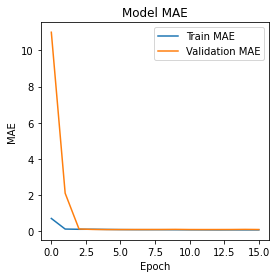

In [35]:
plt.figure(figsize=(9,4))

plt.subplot(1,2,1)
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train MAE', 'Validation MAE'], loc='upper right')

#### Evaluate model on train set

In [36]:
loss, mae = combined_network.evaluate([test_input[0],test_input[1]],test_input[2], verbose=0)

print('Test loss: {}'.format(loss))

Test loss: 0.10409279632568359


### 1-MAE

In [37]:
print('1-MAE: ' + str(1-mae))

1-MAE: 0.8959072008728981


In [38]:
one_minus_mae_train = [1-maee for maee in history.history['mae']]
one_minus_mae_val = [1-maee for maee in history.history['val_mae']]

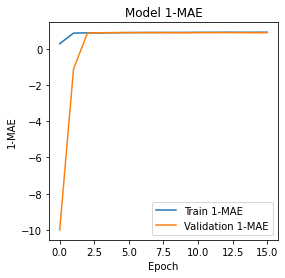

In [39]:
plt.figure(figsize=(9,4))

plt.subplot(1,2,1)
plt.plot(one_minus_mae_train)
plt.plot(one_minus_mae_val)
plt.title('Model 1-MAE')
plt.ylabel('1-MAE')
plt.xlabel('Epoch')
plt.legend(['Train 1-MAE', 'Validation 1-MAE'], loc='lower right')

### Coefficient of determination (R^2)

In [40]:
y_pred = combined_network.predict([test_input[0],test_input[1]])
pred_shape = y_pred.shape
y_pred = y_pred.reshape(pred_shape[0],pred_shape[1],1)

In [41]:
normalized = y_pred / np.max(y_pred)

Text(0.5, 0, 'Y_pred_Neuroticism')

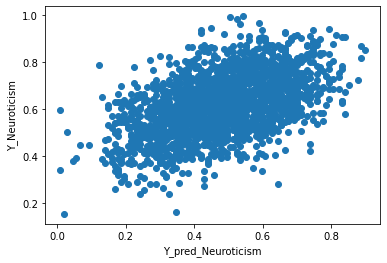

In [46]:
plt.scatter(test_input[2][:,0,:], normalized[:,0,:], marker='o');
plt.ylabel('Y_Neuroticism')
plt.xlabel('Y_pred_Neuroticism')

#### Coefficient Determination (R^2)

In [47]:
from sklearn.metrics import r2_score

In [48]:
pers = ['Neuroticism','Extraversion','Agreeableness','Conscientiousness','Openness']
r2s = [r2_score(test_input[2][:,i,:], normalized[:,i,:]) for i in range(5)]
for pers, r2 in zip(pers,r2s):
    print(pers + ': ' + str(r2))

Neuroticism: -0.6989405380295779
Extraversion: -0.2842172861576431
Agreeableness: -0.4502268578238309
Conscientiousness: -0.661275109694627
Openness: -0.523720135156462
